In [1]:
import torch
from dataloaders.beat import CustomDataset
from dataloaders.build_vocab import Vocab
import pickle
import numpy as np

config_file = open("gesturegen_config.obj", 'rb') 
args = pickle.load(config_file)
args.batch_size = 256

mean_facial = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.facial_rep}/json_mean.npy")).float()
std_facial = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.facial_rep}/json_std.npy")).float()
mean_audio = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.audio_rep}/npy_mean.npy")).float()
std_audio = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.audio_rep}/npy_std.npy")).float()

In [2]:
torch.cuda.is_available()

True

In [3]:
train_data = CustomDataset(args, "train")
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=args.batch_size,  
    shuffle=True,  
    drop_last=True,
)

In [4]:
len(train_loader)

928

In [5]:
val_data = CustomDataset(args, "val")
val_loader = torch.utils.data.DataLoader(
    val_data, 
    batch_size=args.batch_size,  
    shuffle=True,  
    drop_last=True,
)

In [6]:
len(val_loader)

185

In [22]:
data = next(iter(train_loader))
facial = data['facial'] * std_facial.float() + mean_facial.float()
bs_to_flame = torch.from_numpy(np.load('mat_final.npy'))
flame_to_bs = bs_to_flame.pinverse()
facial_flame = facial @ bs_to_flame
print(facial.min(), facial.max(), facial.mean(), facial.std())
print(facial_flame.min(), facial_flame.max(), facial_flame.mean(), facial_flame.std())

tensor(-1.4901e-08) tensor(1.) tensor(0.1258) tensor(0.1400)
tensor(-7.2804) tensor(7.1538) tensor(-0.0157) tensor(0.9628)


In [23]:
print(flame_to_bs.shape)

torch.Size([103, 51])


### Test A2BS SimpleNet

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scripts.Dataset import a2bsDataset
from scripts.MulticontextNet import GestureGen
#import wandb
import uuid

In [25]:
#model_path = 'ckpt_model/multicontextnet-all-vertex-2024/multicontextnet-300.pth'
net = GestureGen(args).cuda()
#net.load_state_dict(torch.load(model_path))
optimizer = torch.optim.Adam( net.parameters(), lr=1e-4)#, weight_decay=1e-5)
train_target_loss = []
train_expressive_loss = []
train_smooth_loss = []
train_mse_loss = []
val_target_loss = []
val_expressive_loss = []
val_smooth_loss = []
val_mse_loss = []

def plot_train_val_loss():
    fig, axs = plt.subplots(1, 4, figsize=(10, 3))
    axs[0].plot(train_target_loss, 'r-')
    axs[0].set_title('Target Loss')
    axs[1].plot(train_expressive_loss, 'p-')
    axs[1].set_title('Expressive Loss')
    axs[2].plot(train_smooth_loss, 'g-')
    axs[2].set_title('Smooth Loss')
    axs[3].plot(train_mse_loss, 'b-')
    axs[3].set_title('MSE Loss')
    fig.suptitle('Training Iterations', fontsize = 16)
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 4, figsize=(10, 3))
    axs[0].plot(val_target_loss, 'r-')
    axs[0].set_title('Target Loss')
    axs[1].plot(val_expressive_loss, 'p-')
    axs[1].set_title('Expressive Loss')
    axs[2].plot(val_smooth_loss, 'g-')
    axs[2].set_title('Smooth Loss')
    axs[3].plot(val_mse_loss, 'b-')
    axs[3].set_title('MSE Loss')
    fig.suptitle('Validation Iterations', fontsize = 16)
    plt.tight_layout()
    plt.show()

In [26]:
print(len(train_data))
data = next(iter(train_loader))
in_audio = data['audio']
facial = data['facial']
in_id = data["id"]
in_word = data["word"]
in_emo = data["emo"]

237714


In [27]:
def expressive_loss_function(output, target): # max squared error over blendshape for each frame, then take the mean
    loss = torch.mean(torch.max((output - target) ** 2, dim=-1).values)
    return loss
# a = torch.tensor([[[1,2,3],[1,2,3]],[[4,5,6],[4,5,6]]]).float()
# b = torch.tensor([[[3,3,4],[2,3,4]],[[5,6,7],[5,6,7]]]).float()
# print(a.shape)
# max_square_error(a, b)

100%|██████████| 928/928 [02:30<00:00,  6.16it/s]


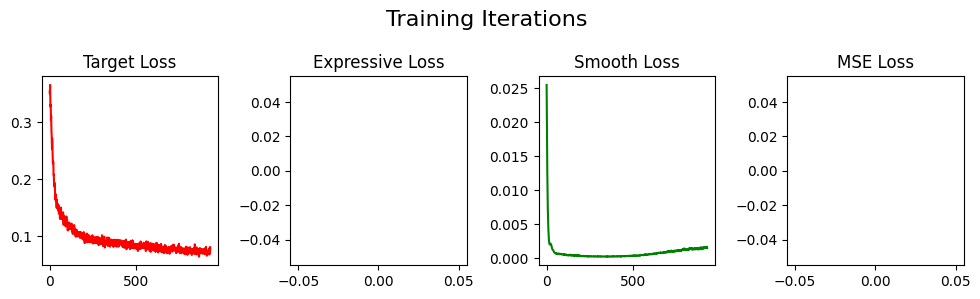

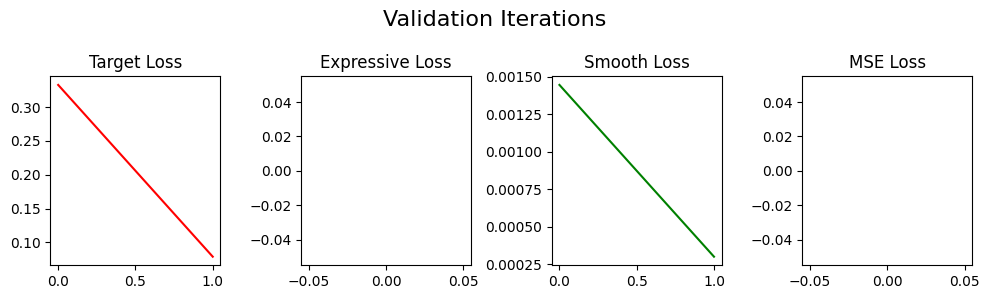

100%|██████████| 928/928 [02:18<00:00,  6.71it/s]


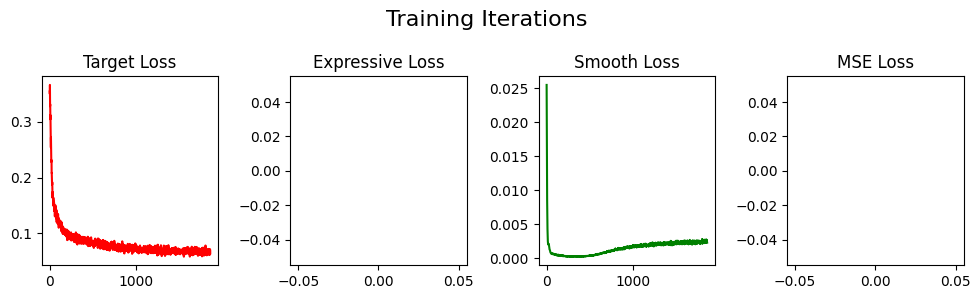

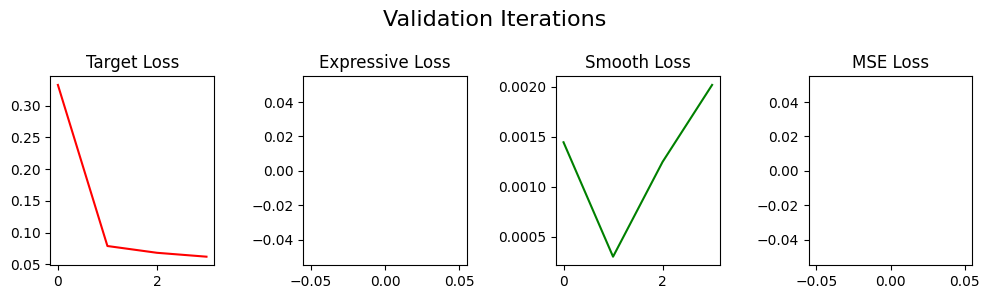

100%|██████████| 928/928 [02:16<00:00,  6.81it/s]


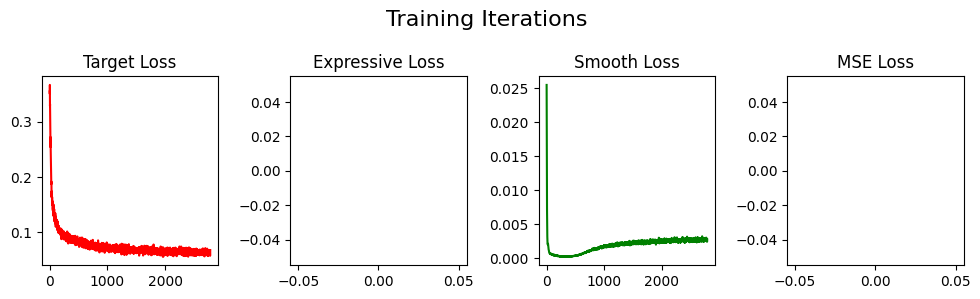

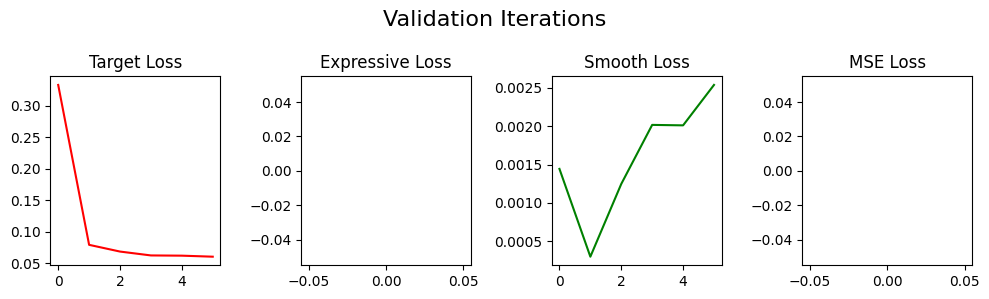

100%|██████████| 928/928 [02:16<00:00,  6.80it/s]


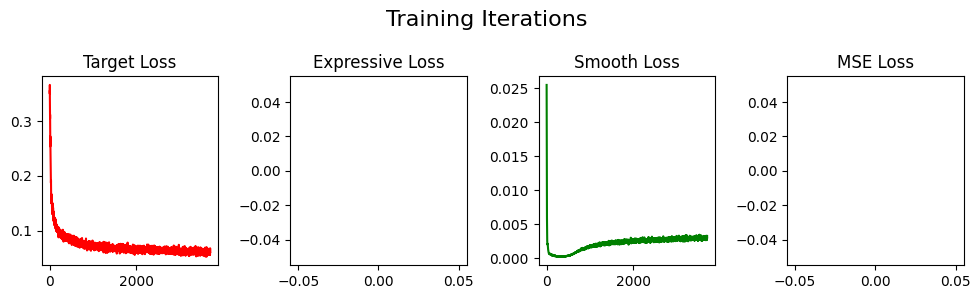

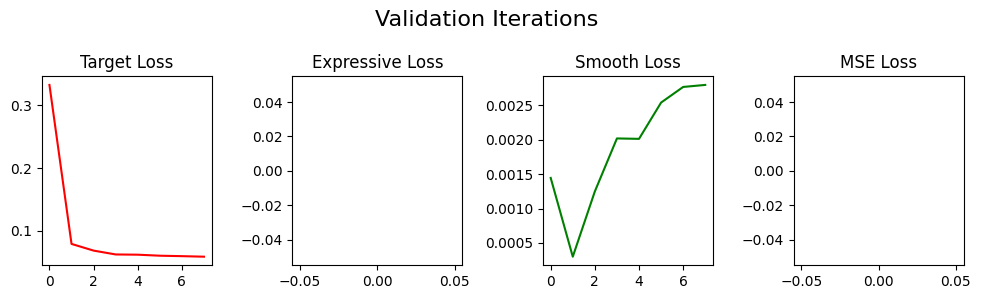

100%|██████████| 928/928 [02:18<00:00,  6.70it/s]


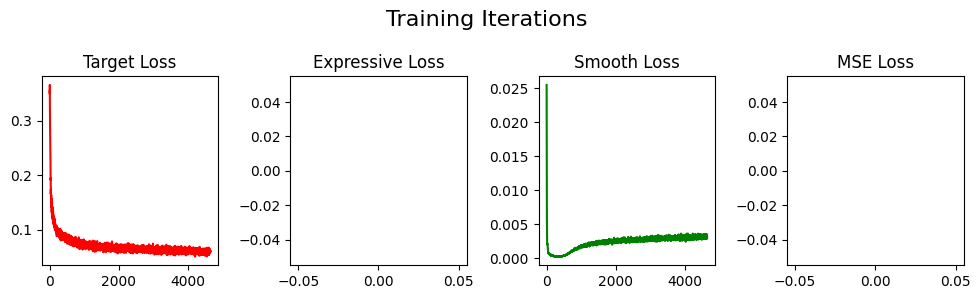

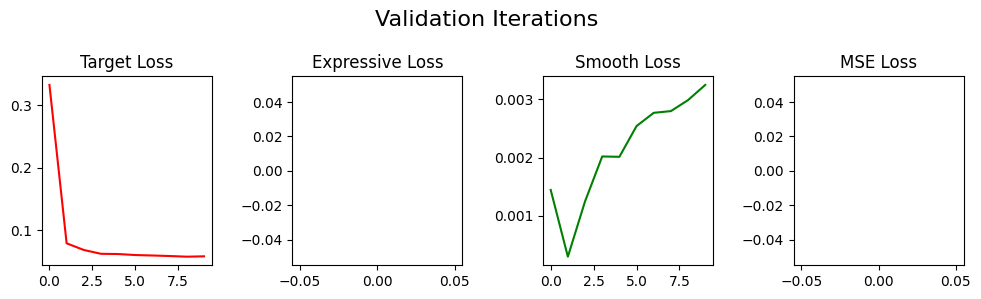

100%|██████████| 928/928 [02:17<00:00,  6.73it/s]


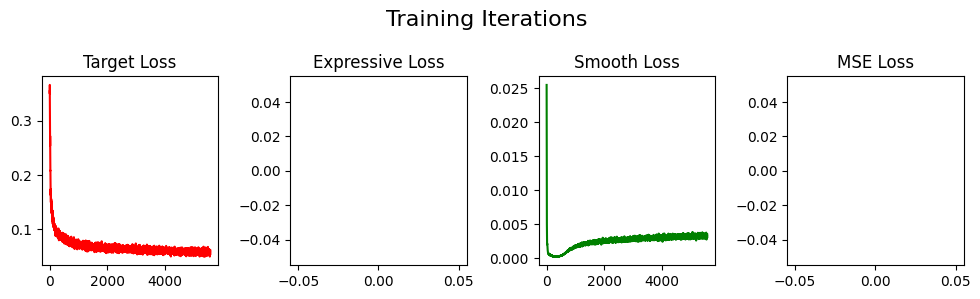

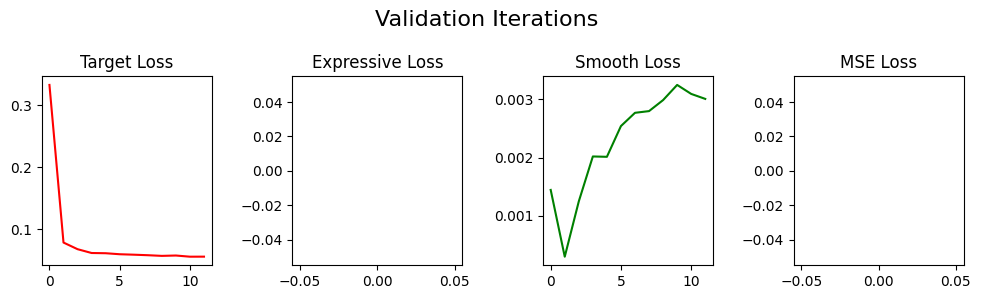

100%|██████████| 928/928 [02:18<00:00,  6.69it/s]


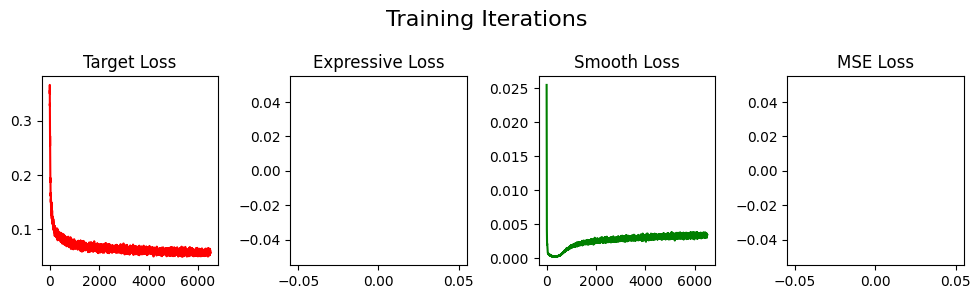

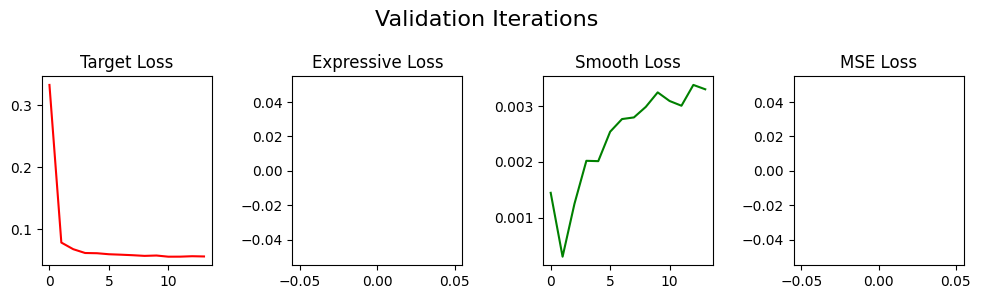

 65%|██████▍   | 600/928 [01:29<00:49,  6.67it/s]


KeyboardInterrupt: 

In [28]:
from tqdm import tqdm
num_epochs = 700
log_period = 200
val_period = 600
val_size = 25
bs_to_flame = torch.from_numpy(np.load('mat_final.npy'))
flame_to_bs = bs_to_flame.pinverse()
target_loss_function = torch.nn.HuberLoss()
smooth_loss_function = torch.nn.CosineSimilarity(dim=2)
mse_loss_function = torch.nn.MSELoss()
target_weight = 1.5
expressive_weight = 0.5
smooth_weight = 0.5

for epoch in range(num_epochs):
    for it, data in enumerate(tqdm(train_loader)):
        net.train()
        in_audio = data['audio']
        facial = data['facial'] * std_facial + mean_facial
        in_id = data["id"]
        in_word = data["word"]
        in_emo = data["emo"]

        in_audio = in_audio.cuda()
        in_facial = torch.cat((facial @ bs_to_flame, facial[:,:,6:14]), dim=-1)
        in_facial = in_facial.cuda()
        in_id = in_id.cuda()
        in_word = in_word.cuda()
        in_emo = in_emo.cuda()

        pre_frames = 4
        if args.predict_flame:
            in_pre_face = in_facial.new_zeros((in_facial.shape[0], in_facial.shape[1], in_facial.shape[2])).cuda()
            in_pre_face[:, 0:pre_frames] = in_facial[:, 0:pre_frames]
        else:
            in_pre_face = in_facial.new_zeros((in_facial.shape[0], in_facial.shape[1], in_facial.shape[2] + 1)).cuda()
            in_pre_face[:, 0:pre_frames, :-1] = in_facial[:, 0:pre_frames]
            in_pre_face[:, 0:pre_frames, -1] = 1 
        
        optimizer.zero_grad()
        out_face = net(in_pre_face,in_audio=in_audio,in_text=in_word, in_id=in_id, in_emo=in_emo)
        target_loss = target_loss_function(out_face,in_facial)# + target_loss_function(out_face[:,:,6:14], in_facial[:,:,6:14]) # to account for eye movement
        #expressive_loss = expressive_loss_function(out_face, in_facial)
        smooth_loss = 1 - smooth_loss_function(out_face[:,:-1,:], out_face[:,1:,:]).mean()
        loss = target_weight * target_loss  + smooth_weight * smooth_loss# + expressive_weight * expressive_loss
        loss.backward()
        optimizer.step()
        
        train_target_loss.append(target_loss.item())
        #train_expressive_loss.append(expressive_loss.item())
        train_smooth_loss.append(smooth_loss.item())
        #train_mse_loss.append(mse_loss_function(out_face.cpu()*std_facial+mean_facial, facial.cpu()*std_facial+mean_facial).item())
        
        #logging
        #if it % log_period == 0:
        #    print(f'[{epoch}][{it}/{len(train_loader)}]: [train] [target loss]: {train_target_loss[-1]} [exp loss]: {train_expressive_loss[-1]} [smooth loss]: {train_smooth_loss[-1]} [mse]: {train_mse_loss[-1]}')
        
        if it % val_period == 0:
            net.eval()
            val_target_loss_st = []
            #val_expressive_loss_st = []
            val_smooth_loss_st = []
            val_mse_loss_st = []
            val_cnt = 0

            val_loader = torch.utils.data.DataLoader(
                val_data, 
                batch_size=args.batch_size,  
                shuffle=True,  
                drop_last=True,
            )
            
            for _, data in enumerate(val_loader):
                in_audio = data['audio']
                facial = data['facial'] * std_facial + mean_facial
                in_id = data["id"]
                in_word = data["word"]
                in_emo = data["emo"]

                in_audio = in_audio.cuda()
                in_facial = torch.cat((facial @ bs_to_flame, facial[:,:,6:14]), dim=-1)
                in_facial = in_facial.cuda()
                in_id = in_id.cuda()
                in_word = in_word.cuda()
                in_emo = in_emo.cuda()

                pre_frames = 4
                if args.predict_flame:
                    in_pre_face = in_facial.new_zeros((in_facial.shape[0], in_facial.shape[1], in_facial.shape[2])).cuda()
                    in_pre_face[:, 0:pre_frames] = in_facial[:, 0:pre_frames]
                else:
                    in_pre_face = in_facial.new_zeros((in_facial.shape[0], in_facial.shape[1], in_facial.shape[2] + 1)).cuda()
                    in_pre_face[:, 0:pre_frames, :-1] = in_facial[:, 0:pre_frames]
                    in_pre_face[:, 0:pre_frames, -1] = 1 

                out_face = net(in_pre_face,in_audio=in_audio,in_text=in_word, in_id=in_id, in_emo=in_emo)
                target_loss = target_loss_function(out_face, in_facial)# + target_loss_function(out_face[:,:,6:14], facial[:,:,6:14])
                #expressive_loss = expressive_loss_function(out_face, facial)
                smooth_loss = 1 - smooth_loss_function(out_face[:,:-1,:], out_face[:,1:,:]).mean()

                val_target_loss_st.append(target_loss.item())
                #val_expressive_loss_st.append(expressive_loss.item())
                val_smooth_loss_st.append(smooth_loss.item())
                #val_mse_loss_st.append(mse_loss_function(out_face.cpu()*std_facial+mean_facial, facial.cpu()*std_facial+mean_facial).item())
                
                
                val_cnt += 1
                if val_cnt >= val_size:
                    break
            
            val_target_loss.append(np.average(val_target_loss_st))
            #val_expressive_loss.append(np.average(val_expressive_loss_st))
            val_smooth_loss.append(np.average(val_smooth_loss_st))
            #val_mse_loss.append(np.average(val_mse_loss_st))
            #print(f'[{epoch}][{it}/{len(train_loader)}]: [val] [target loss]: {val_target_loss[-1]} [exp loss]: {val_expressive_loss[-1]} [smooth loss]: {val_smooth_loss[-1]} [mse]: {val_mse_loss[-1]}')
    plot_train_val_loss()
        

In [29]:
torch.save(net.state_dict(), 'ckpt_model/multicontextnet-flame-7.pth')

In [ ]:
plot_train_val_loss()

### Testing

In [26]:
from pythonosc import udp_client
import time
import sounddevice as sd
import torch
from dataloaders.beat import CustomDataset
from dataloaders.build_vocab import Vocab
import pickle
import numpy as np

config_file = open("gesturegen_config.obj", 'rb') 
args = pickle.load(config_file)
args.batch_size = 16

mean_facial = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.facial_rep}/json_mean.npy")).float()
std_facial = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.facial_rep}/json_std.npy")).float()
mean_audio = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.audio_rep}/npy_mean.npy")).float()
std_audio = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.audio_rep}/npy_std.npy")).float()
bs_to_flame = torch.from_numpy(np.load('mat_final.npy')).float()
flame_to_bs = bs_to_flame.pinverse()

In [27]:
test_data = CustomDataset(args, "test")
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=1,  
    shuffle=True,  
    drop_last=False,
)

In [28]:
data = next(iter(test_loader))

In [29]:
audio = data['audio']
facial = data['facial']
id = data["id"]
word = data["word"]
emo = data["emo"]

In [30]:
out_facial = facial * std_facial + mean_facial
out_audio = audio * std_audio + mean_audio

In [31]:
# Try playing the audio, which is at 16KHZ
print(out_facial.min(), out_facial.max())
print(out_facial.std(), out_facial.mean())

tensor(-7.4506e-09) tensor(0.8493)
tensor(0.1099) tensor(0.1145)


In [32]:
out_audio.shape

torch.Size([1, 1232000])

In [33]:
blend =  [
        "browDownLeft",
        "browDownRight",
        "browInnerUp",
        "browOuterUpLeft",
        "browOuterUpRight",
        "cheekPuff",
        "cheekSquintLeft",
        "cheekSquintRight",
        "eyeBlinkLeft",
        "eyeBlinkRight",
        "eyeLookDownLeft",
        "eyeLookDownRight",
        "eyeLookInLeft",
        "eyeLookInRight",
        "eyeLookOutLeft",
        "eyeLookOutRight",
        "eyeLookUpLeft",
        "eyeLookUpRight",
        "eyeSquintLeft",
        "eyeSquintRight",
        "eyeWideLeft",
        "eyeWideRight",
        "jawForward",
        "jawLeft",
        "jawOpen",
        "jawRight",
        "mouthClose",
        "mouthDimpleLeft",
        "mouthDimpleRight",
        "mouthFrownLeft",
        "mouthFrownRight",
        "mouthFunnel",
        "mouthLeft",
        "mouthLowerDownLeft",
        "mouthLowerDownRight",
        "mouthPressLeft",
        "mouthPressRight",
        "mouthPucker",
        "mouthRight",
        "mouthRollLower",
        "mouthRollUpper",
        "mouthShrugLower",
        "mouthShrugUpper",
        "mouthSmileLeft",
        "mouthSmileRight",
        "mouthStretchLeft",
        "mouthStretchRight",
        "mouthUpperUpLeft",
        "mouthUpperUpRight",
        "noseSneerLeft",
        "noseSneerRight",
        "tongueOut"
    ]

In [34]:
def play_audio(out_audio, init_time):
    time.sleep(init_time - time.time())
    sd.play(out_audio, 16000)
    sd.wait()
    print("Audio finished:", time.time())

In [35]:

def send_udp(out_face, init_time):
    #outWeight = np.zeros(52)

    ##need to implement get value in
    outWeight = out_face

    outWeight = outWeight * (outWeight >= 0)

    client = udp_client.SimpleUDPClient('127.0.0.1', 5008)
    osc_array = outWeight.tolist()
    
    fps = 15
    time.sleep(init_time - time.time())
    #start_time = time.time()
    for i in range(len(osc_array)):
        #print(out_face[i].shape)
        for j, out in enumerate(osc_array[i]):
            client.send_message('/' + str(blend[j]), out)

        elpased_time = time.time() - init_time
        sleep_time = 1.0/fps * (i+1) - elpased_time
        if sleep_time > 0:
            time.sleep(sleep_time)
        #start_time = time.time()
    print("Facial finished:", time.time())

In [12]:
import threading

init_time = time.time() + 1

limit_sec = 20

udp_thread = threading.Thread(target=send_udp, args=(out_facial[0, 0:limit_sec*15],init_time))
udp_thread.daemon = True  # Set the thread as a daemon to allow it to exit when the main program exits

audio_thread = threading.Thread(target=play_audio, args=(out_audio[0, 0:limit_sec*16000],init_time-0.3))
audio_thread.daemon = True

udp_thread.start()
audio_thread.start()

udp_thread.join()
audio_thread.join()

Audio finished: 1717834376.0518866
Facial finished: 1717834376.266896


In [36]:
print(len(out_audio[0])/16000, len(out_facial[0])/15)

77.0 77.0


In [39]:
 # load in model
from scripts.MulticontextNet import GestureGen
#model_path = 'ckpt_model/multicontextnet-flame-7.pth'
model_path = 'ckpt_model/multicontextnet-bs_no_text-2024/multicontextnet-1000.pth'
#model_path = 'ckpt_model/multicontextnet-bs2vertices-2024/multicontextnet-500.pth'
#model_path = 'ckpt_model/multicontextnet100.pth'
#args.predict_flame = False
net = GestureGen(args)
net.load_state_dict(torch.load(model_path))
net = net.cuda().eval()

RuntimeError: Error(s) in loading state_dict for GestureGen:
	Missing key(s) in state_dict: "text_encoder.embedding.weight", "text_encoder.tcn.network.0.conv1.bias", "text_encoder.tcn.network.0.conv1.weight_g", "text_encoder.tcn.network.0.conv1.weight_v", "text_encoder.tcn.network.0.conv2.bias", "text_encoder.tcn.network.0.conv2.weight_g", "text_encoder.tcn.network.0.conv2.weight_v", "text_encoder.tcn.network.0.net.0.bias", "text_encoder.tcn.network.0.net.0.weight_g", "text_encoder.tcn.network.0.net.0.weight_v", "text_encoder.tcn.network.0.net.4.bias", "text_encoder.tcn.network.0.net.4.weight_g", "text_encoder.tcn.network.0.net.4.weight_v", "text_encoder.tcn.network.0.downsample.weight", "text_encoder.tcn.network.0.downsample.bias", "text_encoder.tcn.network.1.conv1.bias", "text_encoder.tcn.network.1.conv1.weight_g", "text_encoder.tcn.network.1.conv1.weight_v", "text_encoder.tcn.network.1.conv2.bias", "text_encoder.tcn.network.1.conv2.weight_g", "text_encoder.tcn.network.1.conv2.weight_v", "text_encoder.tcn.network.1.net.0.bias", "text_encoder.tcn.network.1.net.0.weight_g", "text_encoder.tcn.network.1.net.0.weight_v", "text_encoder.tcn.network.1.net.4.bias", "text_encoder.tcn.network.1.net.4.weight_g", "text_encoder.tcn.network.1.net.4.weight_v", "text_encoder.tcn.network.2.conv1.bias", "text_encoder.tcn.network.2.conv1.weight_g", "text_encoder.tcn.network.2.conv1.weight_v", "text_encoder.tcn.network.2.conv2.bias", "text_encoder.tcn.network.2.conv2.weight_g", "text_encoder.tcn.network.2.conv2.weight_v", "text_encoder.tcn.network.2.net.0.bias", "text_encoder.tcn.network.2.net.0.weight_g", "text_encoder.tcn.network.2.net.0.weight_v", "text_encoder.tcn.network.2.net.4.bias", "text_encoder.tcn.network.2.net.4.weight_g", "text_encoder.tcn.network.2.net.4.weight_v", "text_encoder.tcn.network.3.conv1.bias", "text_encoder.tcn.network.3.conv1.weight_g", "text_encoder.tcn.network.3.conv1.weight_v", "text_encoder.tcn.network.3.conv2.bias", "text_encoder.tcn.network.3.conv2.weight_g", "text_encoder.tcn.network.3.conv2.weight_v", "text_encoder.tcn.network.3.net.0.bias", "text_encoder.tcn.network.3.net.0.weight_g", "text_encoder.tcn.network.3.net.0.weight_v", "text_encoder.tcn.network.3.net.4.bias", "text_encoder.tcn.network.3.net.4.weight_g", "text_encoder.tcn.network.3.net.4.weight_v", "text_encoder.decoder.weight", "text_encoder.decoder.bias". 
	size mismatch for gru.weight_ih_l0: copying a param with shape torch.Size([768, 196]) from checkpoint, the shape in current model is torch.Size([768, 324]).
	size mismatch for gru.weight_ih_l0_reverse: copying a param with shape torch.Size([768, 196]) from checkpoint, the shape in current model is torch.Size([768, 324]).
	size mismatch for audio_fusion.0.weight: copying a param with shape torch.Size([128, 144]) from checkpoint, the shape in current model is torch.Size([128, 272]).

In [18]:
in_audio = audio.cuda()
bs_facial = facial * std_facial.float() + mean_facial.float()
#flame_facial = torch.cat((bs_facial @ bs_to_flame, bs_facial[:,:,6:14]), dim=-1)
in_id = id.cuda()
in_word = word.cuda()
in_emo = emo.cuda()
#in_emo = torch.zeros_like(emo) + 1
#in_emo = in_emo.cuda()
pre_frames = 4
in_pre_facial = bs_facial.new_zeros((bs_facial.shape[0], bs_facial.shape[1], bs_facial.shape[2] + 1)).cuda() 
in_pre_facial[:, 0:pre_frames, :-1] = bs_facial[:, 0:pre_frames]
in_pre_facial[:, 0:pre_frames, -1] = 1 
#in_pre_facial = in_facial.new_zeros((flame_facial.shape[0], flame_facial.shape[1], flame_facial.shape[2])).cuda() 
#in_pre_facial[:, 0:pre_frames] = flame_facial[:, 0:pre_frames]

In [20]:
pred_facial = net(in_pre_facial, in_audio=in_audio, in_text=in_word, in_id=in_id, in_emo=in_emo).cpu().detach()
#pred_facial = pred_facial * std_facial + mean_facial

In [21]:
print(bs_facial.cpu().min(), bs_facial.cpu().max())
print(bs_facial.cpu().std(), bs_facial.cpu().mean())
print(pred_facial.min(), pred_facial.max())
print(pred_facial.std(), pred_facial.mean())

tensor(-7.4506e-09) tensor(0.8154)
tensor(0.1432) tensor(0.1203)
tensor(-0.3083) tensor(1.1192)
tensor(0.2013) tensor(0.1104)


In [22]:
# pred_bs_facial = pred_facial[:,:,:103] @ flame_to_bs
# pred_bs_facial[:,:,6:14] = pred_facial[:,:,103:111]

In [24]:
import threading

init_time = time.time() + 1

limit_sec = 70

udp_thread = threading.Thread(target=send_udp, args=(pred_facial[0,0:limit_sec*15],init_time))
udp_thread.daemon = True  # Set the thread as a daemon to allow it to exit when the main program exits

audio_thread = threading.Thread(target=play_audio, args=(out_audio[0,0:limit_sec*16000],init_time-0.3))
audio_thread.daemon = True

udp_thread.start()
audio_thread.start()

udp_thread.join()
audio_thread.join()

Audio finished: 1717834780.564286
Facial finished: 1717834780.7972963


In [64]:
print(expressive_loss_function(pred_bs_facial, bs_facial))
print(torch.nn.functional.mse_loss(pred_bs_facial, bs_facial))
print(torch.nn.functional.mse_loss(pred_flame_facial, flame_facial))

tensor(0.0727)
tensor(0.0090)
tensor(0.1161)


In [65]:
print(expressive_loss_function(pred_bs_facial, bs_facial))
print(torch.nn.functional.mse_loss(pred_bs_facial, bs_facial))
print(torch.nn.functional.mse_loss(pred_flame_facial, flame_facial))

tensor(0.0727)
tensor(0.0090)
tensor(0.1161)
